# Imports

In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [6]:
# Do this if you are using the datasets from your drive
from google.colab import drive
drive.mount('/content/drive/'
)

Mounted at /content/drive/


In [7]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 9), reused 10 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), 931.26 KiB | 5.26 MiB/s, done.


In [8]:
from Wind.dataset import Dataset
from Wind.utils import score_function
from Wind.model import *

In [9]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [11]:
# Change directory to the dataset
csv_name= '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2020_3086/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv'
csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9} # This part is copied from data provider check references
df = pd.read_csv(csv_name,**csv_params)

# Change directory to the dataset
test_csv_name = '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2021_3087/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv'
csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9}# This part is copied from data provider check references
test_df = pd.read_csv(csv_name,**csv_params)

concatenated_df = pd.concat([df, test_df]) # Concatanate test and train data
test_split = len(test_df)/len(concatenated_df)

In [12]:
# This part is also copied from data provider, fields look good in terms of statistics
use_columns = [ 'Wind speed (m/s)','Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)',
            'Wind speed, Maximum (m/s)','Wind direction (°)','Nacelle position (°)','Energy Export (kWh)','Power (kW)',
            'Reactive power (kvar)','Rotor speed (RPM)','Generator RPM (RPM)','Nacelle ambient temperature (°C)',
            'Blade angle (pitch position) A (°)','Blade angle (pitch position) B (°)','Blade angle (pitch position) C (°)',
            'Lost Production to Curtailment (Total) (kWh)','Lost Production to Downtime (kWh)','Metal particle count counter',
            'Front bearing temperature (°C)','Rear bearing temperature (°C)']

In [13]:
roll_window = 4
dataset = Dataset(concatenated_df[use_columns])
dataset.fill_nan(use_columns)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
# Rolling means selected heuristicly
dataset.apply_rolling_window(dataset.df,'Wind speed (m/s)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Nacelle ambient temperature (°C)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Generator RPM (RPM)' , roll_window,np.mean)

# Modelling



## Next Step Prediction



In [17]:
horizon = 1
window = 144

train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,target_col = 'Power (kW)',test_split= test_split)


In [18]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.090136
0:	learn: 655.1108639	test: 613.9549144	best: 613.9549144 (0)	total: 101ms	remaining: 1m 40s
500:	learn: 23.3814541	test: 31.6662500	best: 31.6564051 (488)	total: 10.8s	remaining: 10.8s
999:	learn: 22.0612176	test: 31.0288927	best: 31.0283179 (991)	total: 21.8s	remaining: 0us
bestTest = 31.02831788
bestIteration = 991
Shrink model to first 992 iterations.


                  MAE       RMSE        R2
Validation  18.146819  31.028285  0.997868
Test        15.548771  26.000330  0.998622


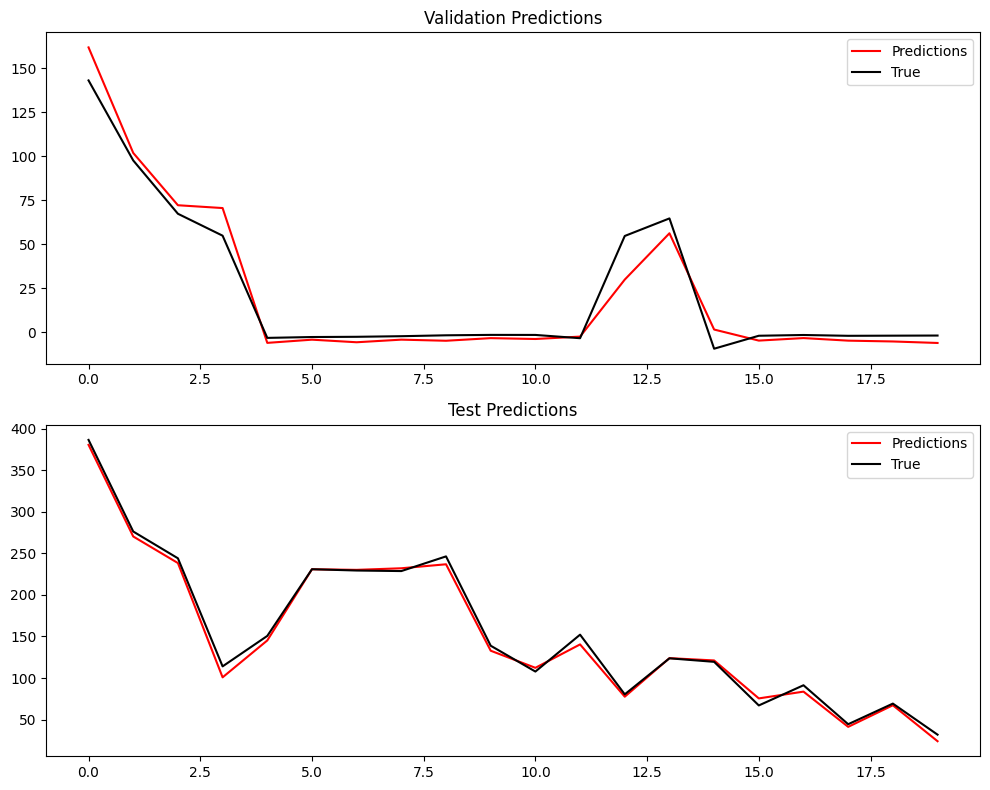

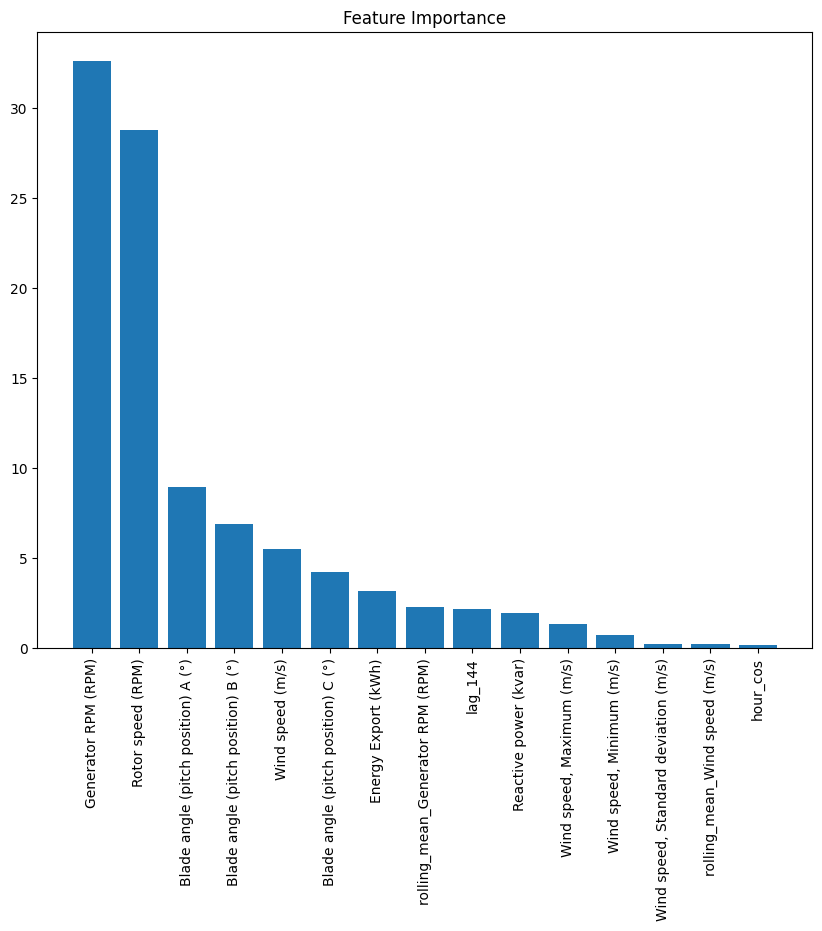

In [19]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=20, feat_importance=True, feat_steps=15,feat_names=columns)



## Next Hour One shot Prediction



In [14]:
horizon = 6
window = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                              window, horizon,target_col = 'Power (kW)',test_split= 0.5)

In [15]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False) # we need to predict last step hence take the last element of y values

Learning rate set to 0.090134
0:	learn: 663.9118434	test: 623.2239506	best: 623.2239506 (0)	total: 45.6ms	remaining: 45.5s
500:	learn: 210.9801321	test: 278.7967967	best: 256.4042168 (51)	total: 15.7s	remaining: 15.6s
999:	learn: 191.8486409	test: 297.6802219	best: 256.4042168 (51)	total: 28.9s	remaining: 0us
bestTest = 256.4042168
bestIteration = 51
Shrink model to first 52 iterations.


                   MAE        RMSE        R2
Validation  181.837058  256.404220  0.854435
Test        173.189109  248.638019  0.873963


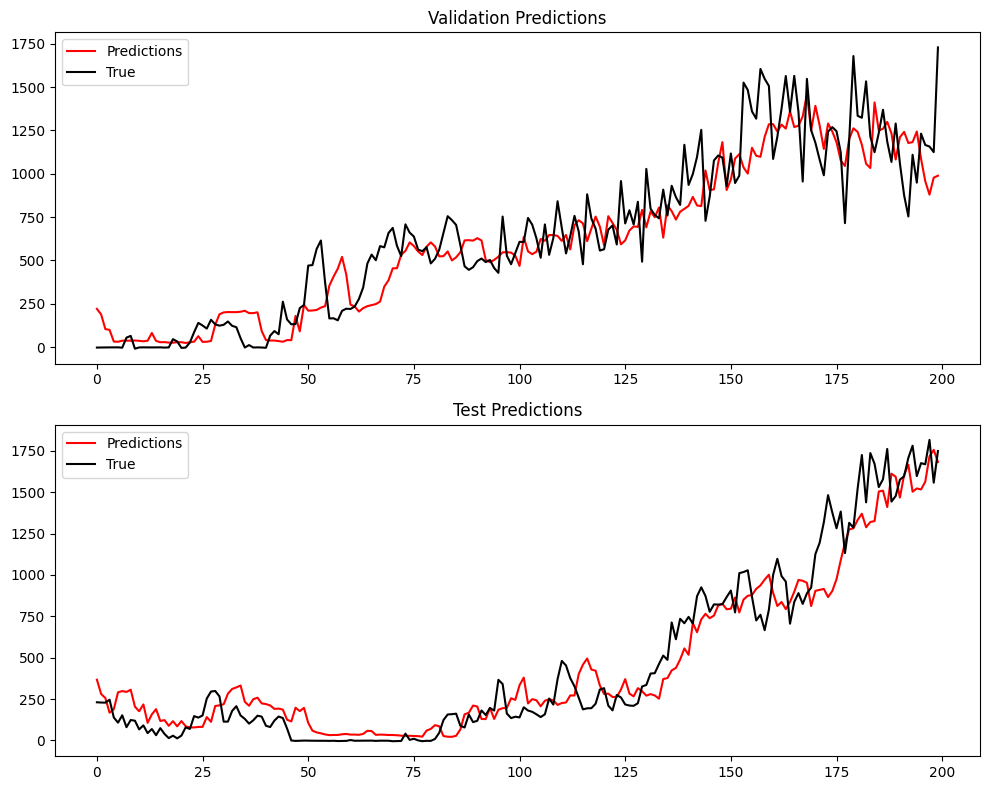

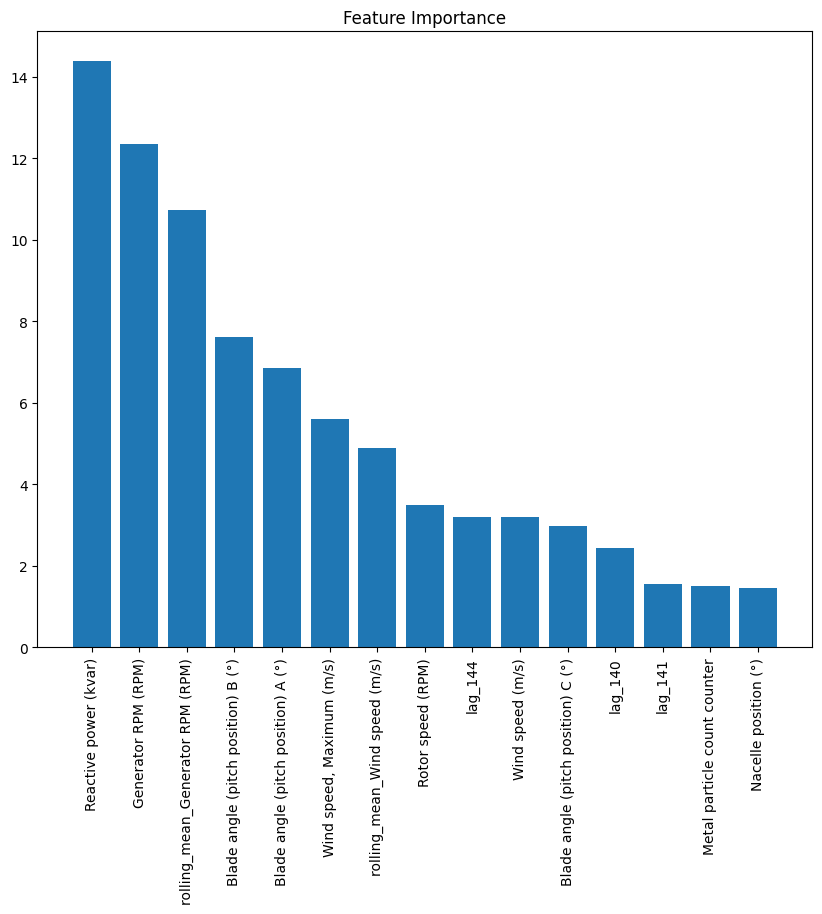

In [16]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns)



## Next Hour Recursive Prediction



In [20]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 6,target_col ='Power (kW)',test_split = 0.5,univariate= True)

In [21]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.090134
0:	learn: 658.4494355	test: 617.2782679	best: 617.2782679 (0)	total: 79.7ms	remaining: 1m 19s
500:	learn: 139.6772030	test: 149.8694212	best: 149.8198627 (454)	total: 13.3s	remaining: 13.2s
999:	learn: 132.9468105	test: 150.2838612	best: 149.8198627 (454)	total: 24.1s	remaining: 0us
bestTest = 149.8198627
bestIteration = 454
Shrink model to first 455 iterations.


                   MAE        RMSE        R2
Validation  113.695710  164.672314  0.939956
Test        112.154547  166.031797  0.943795


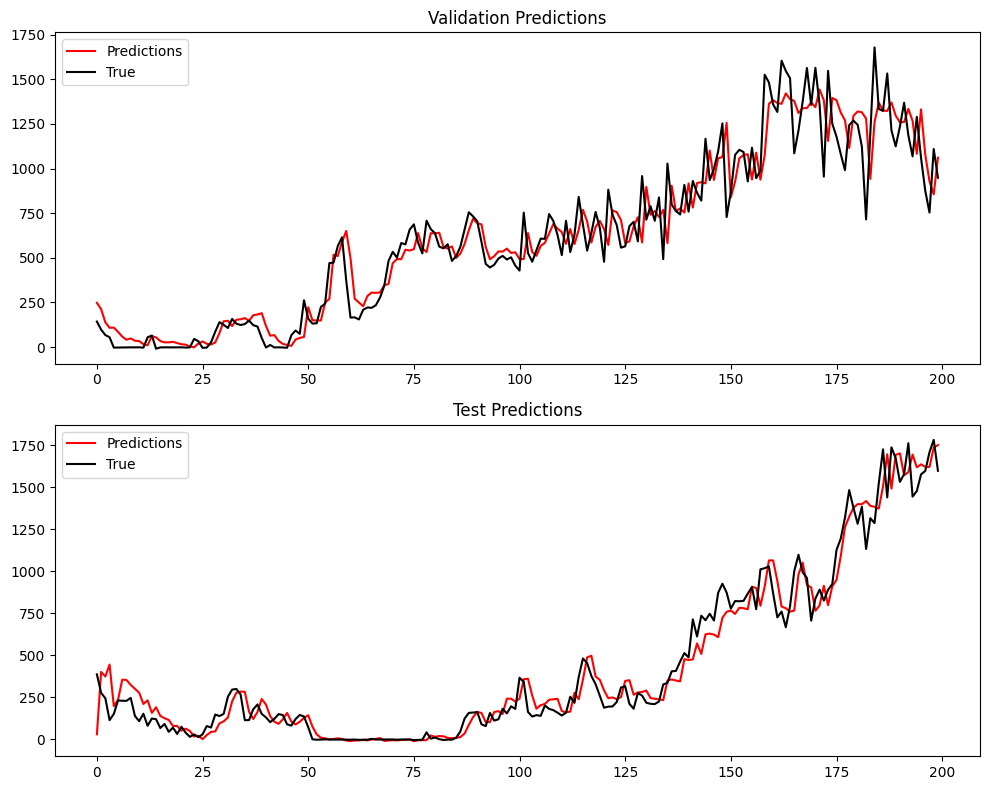

In [22]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)



## Next Day One Shot Prediction



In [23]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5)

In [24]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1], multioutput= False)

Learning rate set to 0.090092
0:	learn: 695.7522998	test: 663.5875335	best: 663.5875335 (0)	total: 107ms	remaining: 1m 46s
500:	learn: 296.4949047	test: 792.7326805	best: 628.0519644 (23)	total: 15.1s	remaining: 15s
999:	learn: 244.0295457	test: 812.2275779	best: 628.0519644 (23)	total: 28.4s	remaining: 0us
bestTest = 628.0519644
bestIteration = 23
Shrink model to first 24 iterations.


                   MAE        RMSE        R2
Validation  534.710762  628.051976  0.129579
Test        481.773256  576.275680  0.323186


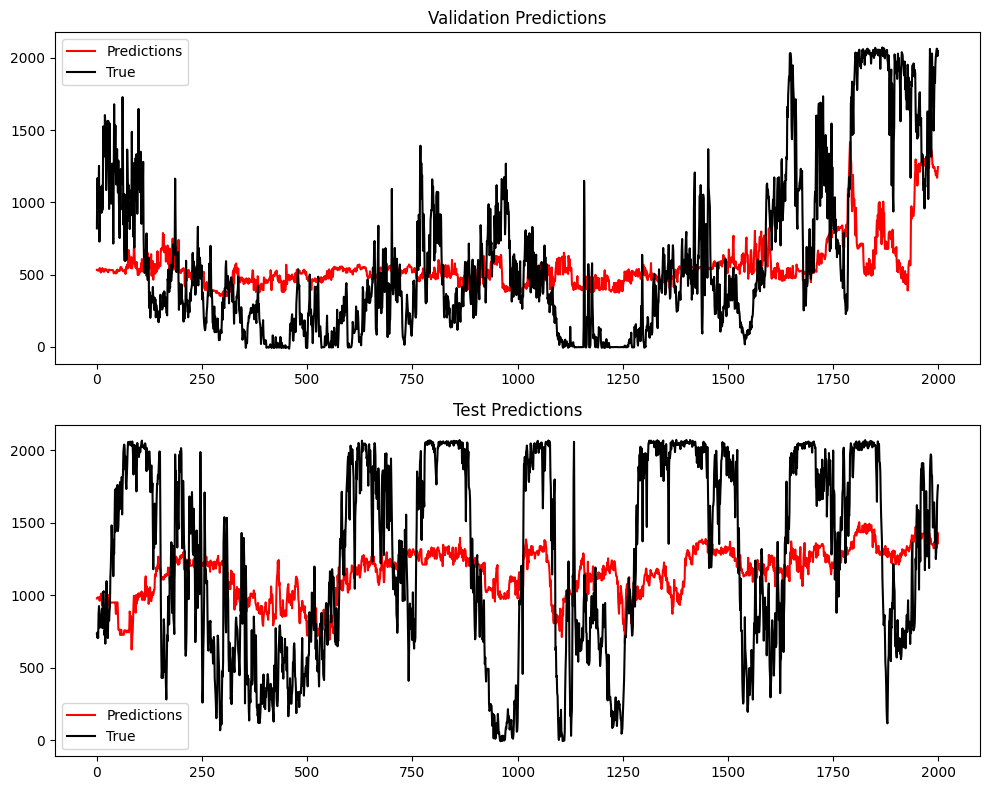

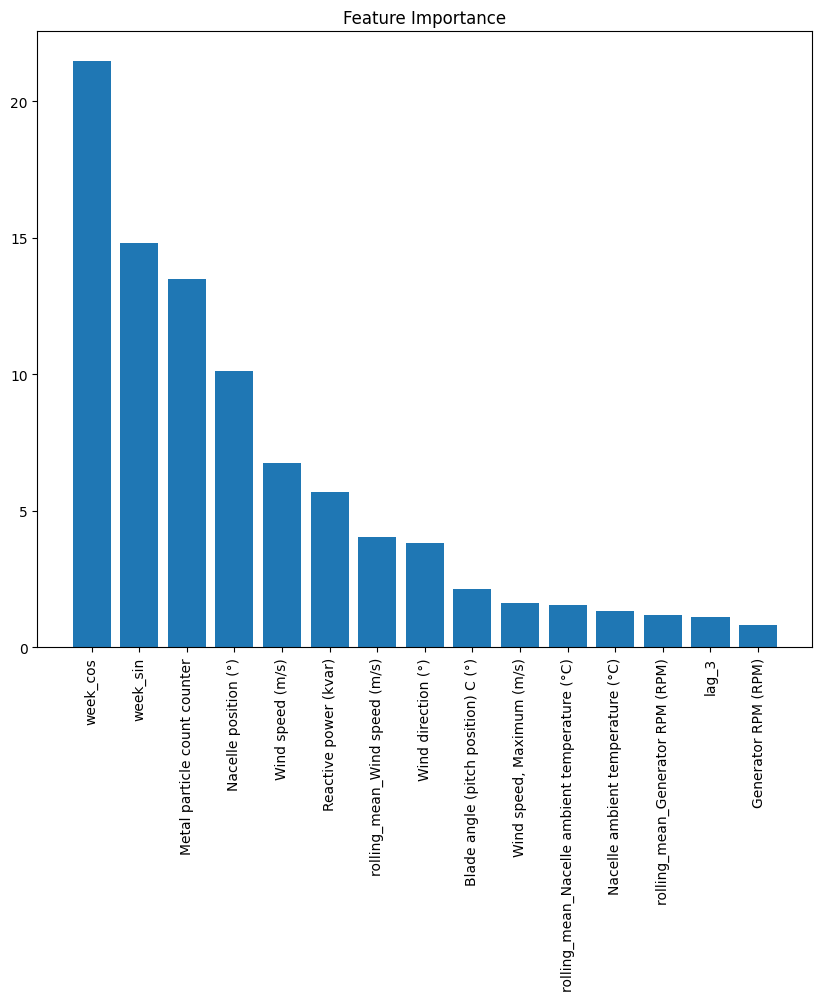

In [25]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns)



## Next Day Recursive Prediction



In [26]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5,univariate=True)

In [27]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.090092
0:	learn: 658.5321963	test: 617.0204855	best: 617.0204855 (0)	total: 34.6ms	remaining: 34.6s
500:	learn: 140.0094092	test: 150.2937703	best: 150.1852392 (246)	total: 12.1s	remaining: 12.1s
999:	learn: 133.6489711	test: 150.6516504	best: 150.1852392 (246)	total: 21.5s	remaining: 0us
bestTest = 150.1852392
bestIteration = 246
Shrink model to first 247 iterations.


                   MAE        RMSE        R2
Validation  156.595045  219.332072  0.893382
Test        169.748817  242.492373  0.880075


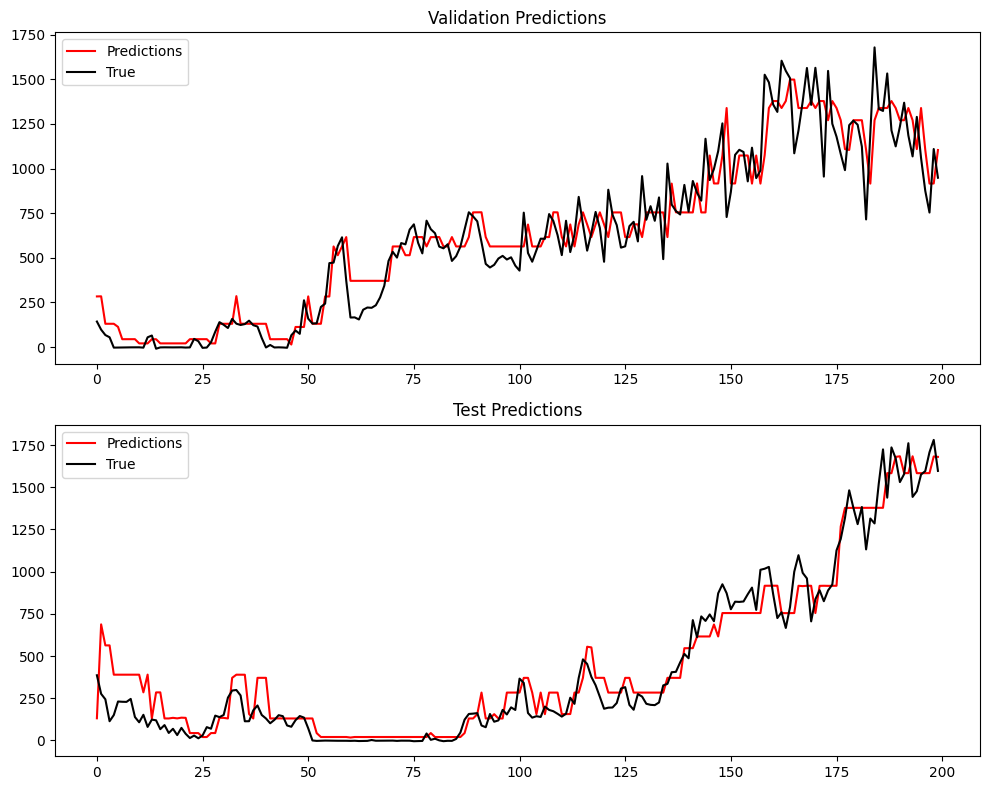

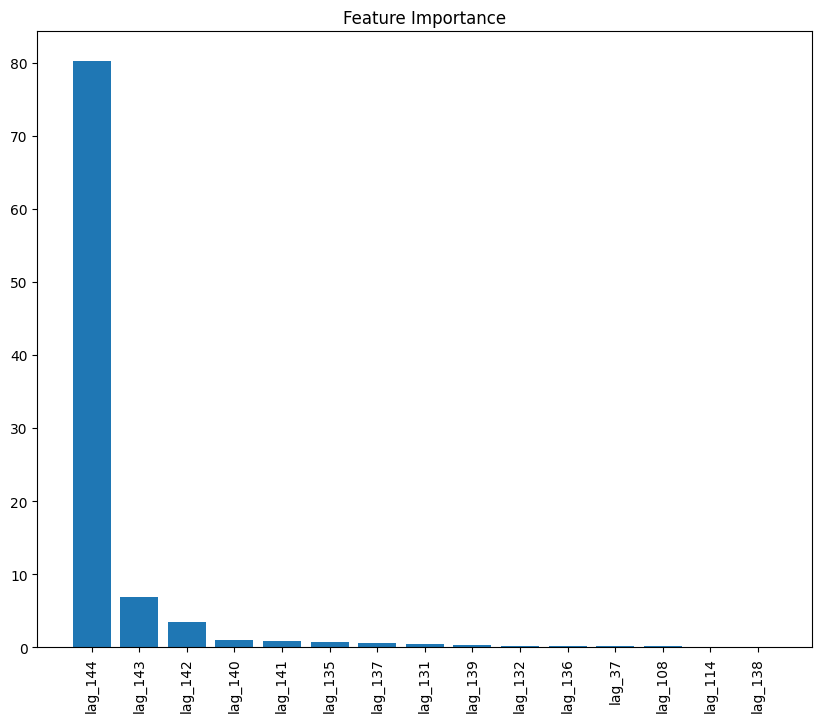

In [28]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [66]:
from tabulate import tabulate

results = [next_step_os.iloc[1,:],next_hour_os.iloc[1,:],next_day_os.iloc[1,:],
           next_hour_rec.iloc[1,:],next_day_rec.iloc[1,:]]

names = ['Next Step One Shot', 'Next Hour One Shot', 'Next Day One Shot',
         'Next Hour Recursive', 'Next Day Recursive']
metrics = ['MAE', 'RMSE', 'R2']

header = ['Metric'] + metrics
table_data = []

# Append MAE, RMSE, and R2 values for the test set

for i,n in enumerate(names):
  value = [n] + [results[i]['MAE']] + [results[i]['RMSE']]+ [results[i]['R2']]
  table_data.append(value)
table = tabulate(table_data, headers=header, tablefmt='pipe')
print(table)

| Metric              |      MAE |     RMSE |       R2 |
|:--------------------|---------:|---------:|---------:|
| Next Step One Shot  |  15.5488 |  26.0003 | 0.998622 |
| Next Hour One Shot  | 173.189  | 248.638  | 0.873963 |
| Next Day One Shot   | 481.773  | 576.276  | 0.323186 |
| Next Hour Recursive | 112.155  | 166.032  | 0.943795 |
| Next Day Recursive  | 169.749  | 242.492  | 0.880075 |
